In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb
from copy import copy

In [2]:
## figure plotting configurations


plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

### Age profile of income 

In [3]:
## some life cycle paras 
T = 40
L = 60

T_q = T*4
L_q = L*4

In [4]:
def y2q_interpolate(xs_y):
    
    """
    this function turns an array of yealry rates into quarterly rates via linear interpolation 
    """

    n_y = len(xs_y)
    y_id = np.arange(n_y)
    q_id = y_id*4

    n_q = 4*n_y
    xs_q = np.empty(n_q)
    
    for i_y in range(n_y):
        xs_q[4*i_y] = xs_y[i_y]
        for i_q in np.arange(1,4):
            q_id_this = 4*i_y+i_q
            xs_q[q_id_this] = np.interp(q_id_this,q_id,xs_y)
            
    return xs_q

In [5]:
age_profile = pd.read_stata('../OtherData/age_profile.dta')  

In [6]:
age_profile_data ='SIPP'

if age_profile_data=='SIPP':
    ## import age income profile 

    age_profile = pd.read_stata('../OtherData/age_profile.dta')   

    ## select age range for the model and turn it into an array 
    lc_wages = np.array(age_profile[(age_profile['age']>=24) &(age_profile['age']<=64)]['wage_age'])
    #print(str(len(lc_wages)),'years since age 25')

    ## growth rates since initial age over life cicle before retirement
    lc_G = lc_wages[1:]/lc_wages[:-1]

    ## growth rates after retirement

    lc_G_rt = np.ones(L-T)
    lc_G_rt[0] = 1/np.cumprod(lc_G)[-1]


    lc_G_full = np.concatenate([lc_G,lc_G_rt])
    assert len(lc_G_full) == L,'length of G needs to be equal to L'
    #lc_G_full = np.ones_like(lc_G_full)

    
    ## turn yearly number to quarterly number with interpolation 

    ## get the quarterly income profile over life cycle before retirement 
    lc_G_q = y2q_interpolate(lc_G)

    lc_G_q_rt = y2q_interpolate(lc_G_rt)

    lc_G_q_full = np.concatenate([lc_G_q,lc_G_q_rt])
    
    
elif age_profile_data=='SCF':
    ## import age income profile 
    SCF_profile = pd.read_pickle('data/SCF_age_profile.pkl')
    SCF_profile = SCF_profile[(SCF_profile.index>=24) & (SCF_profile.index<=85)]
    lc_p_incom = np.exp(np.array(SCF_profile['av_lnorminc']))
    lc_G_full = lc_p_incom[1:]/lc_p_incom[:-1] 
    assert len(lc_G_full) == L,'length of G needs to be equal to L'
    lc_G_q_full = y2q_interpolate(lc_G_full)

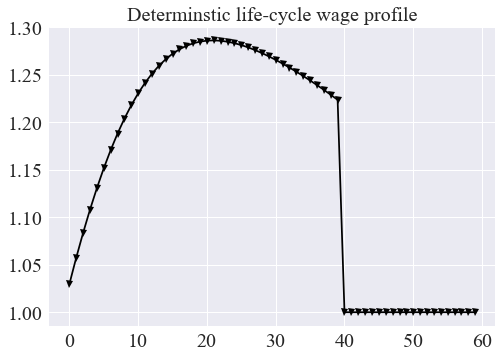

In [15]:
if __name__ == "__main__":
    plt.title('Determinstic life-cycle wage profile')
    plt.plot(np.cumprod(lc_G_full),
            'k-v')
    plt.savefig('../Graphs/sipp/age_wage_profile.pdf')

In [81]:
## subjective growth expectations 


SCE = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   
SCE = SCE.rename(columns={'Q24_mean': 'incexp',
                       'Q24_var': 'incvar',
                       'Q24_iqr': 'inciqr',
                       'Q24_rmean':'rincexp',
                       'Q24_rvar': 'rincvar',
                       'Q13new':'UE_s',
                       'Q22new':'UE_f'
                       })
SCE = SCE.rename(columns = {'D6':'HHinc',
                          'Q10_1':'fulltime',
                          'Q10_2':'parttime',
                          'Q12new':'selfemp',
                          'Q32':'age',
                          'Q33':'gender',
                          'Q36':'educ'})

lc_G_sub = np.array(1+SCE[(SCE['age']>=26) &(SCE['age']<64)].groupby('age')['rincexp'].mean())
## growth rates after retirement
lc_G_rt_sub = np.ones(L-T)
#lc_G_rt[0] = 1/np.cumprod(lc_G)[-1]
#lc_G_rt = lc_G_rt*lc_G[-1]
lc_G_full_sub = np.concatenate([lc_G_sub,lc_G_rt_sub])
assert len(lc_G_full_sub) == L,'length of G needs to be equal to L'
lc_G_q_full_sub = y2q_interpolate(lc_G_full_sub)

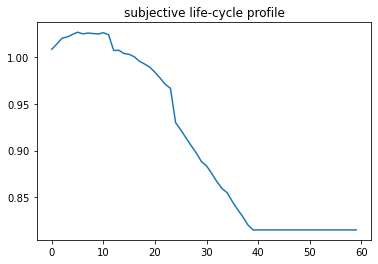

In [82]:
if __name__ == "__main__":
    plt.title('subjective life-cycle profile')
    plt.plot(np.cumprod(lc_G_full_sub))

### Income risk estimates 

In [83]:
risks_est = pd.read_stata('../OtherData/sipp/sipp_history_vol_decomposed.dta')
## risks of permanent and transitory component 

σ_ψ_q_sipp = np.sqrt(risks_est['permanent']**2*3)
σ_θ_q_sipp = np.sqrt(risks_est['permanent']**2/3)

## p/t ratio 
kappas_sipp  = risks_est['permanent']/risks_est['transitory']
kappa_sipp = np.median(kappas_sipp.dropna())

In [84]:
## risks of permanent and transitory component 

σ_ψ_q_sipp = np.sqrt(risks_est['permanent']**2*3)
σ_θ_q_sipp = np.sqrt(risks_est['permanent']**2/3)

## p/t ratio 
kappas_sipp  = risks_est['permanent']/risks_est['transitory']
kappa_sipp = np.median(kappas_sipp.dropna())

### Initial conditions

In [85]:
from statsmodels.stats.weightstats import DescrStatsW

## SCF data 
SCF2016 = pd.read_stata('rscfp2016.dta')
SCF2016 = SCF2016[SCF2016['age']==25]
SCF2016 = SCF2016.drop_duplicates(subset=['yy1'])
SCF2016 = SCF2016[['norminc','networth','wgt']]
SCF2016 = SCF2016[SCF2016['norminc']>0]

## permanent income at age 25 
pinc_SCF = SCF2016[['norminc','wgt']]
lpinc_SCF_pos, lpinc_SCF_wgt = np.log(pinc_SCF['norminc']),np.array(pinc_SCF['wgt'])

## wealth 
b_SCF = SCF2016[['networth','wgt']]
lb_SCF_pos, lb_SCF_wgt = b_SCF['networth'],np.array(b_SCF['wgt'])

## wealth to permanent income
SCF2016['networth2pinc'] = SCF2016['networth']/SCF2016['norminc']
b_SCF, b_wgt = SCF2016['networth2pinc'], SCF2016['wgt']

## compute data moments 
σ_ψ_init_SCF = DescrStatsW(lpinc_SCF_pos, weights=lpinc_SCF_wgt, ddof=1).std
σ_b_init_SCF = DescrStatsW(lb_SCF_pos, weights=lb_SCF_wgt, ddof=1).std
b_SCF = DescrStatsW(b_SCF,weights=b_wgt, ddof=1).mean ## annual 
b_q_SCF = b_SCF*4  ## quarterly  

### subjective profile estiamtion 

In [86]:
## subjective constant profile 

sigma_eps_sub = np.sqrt(1/(1+kappa_sipp**2)*0.04**2) ## 0.04 is an upper bound for the average PR in standard deviation from SCE 
sigma_psi_sub = sigma_eps_sub*kappa_sipp

if __name__ == "__main__":    
    print('perceived transitory PR:',sigma_eps_sub)
    print('perceived permanent PR:',sigma_psi_sub)

perceived transitory PR: 0.019741924602425832
perceived permanent PR: 0.034788739744235256


In [87]:
## subjective markov profile 


## import subjective profile estimation results 
SCE_est_q = pd.read_pickle('data/subjective_profile_est_q.pkl')
SCE_est_y = pd.read_pickle('data/subjective_profile_est_y.pkl')
SCE_est_q = SCE_est_q['baseline']
SCE_est_y = SCE_est_y['baseline']
P_sub_q = np.array([[SCE_est_q.loc['$q$'],1-SCE_est_q.loc['$q$']],
                    [1-SCE_est_q.loc['$p$'],SCE_est_q.loc['$p$']]])
P_sub_y = np.array([[SCE_est_y.loc['$q$'],1-SCE_est_y.loc['$q$']],
                    [1-SCE_est_y.loc['$p$'],SCE_est_y.loc['$p$']]])

In [88]:
SCE_est_q

$std(\tilde\sigma)$        1.189659
$q$                        0.975694
$p$                        0.975694
$\tilde\sigma^l_\psi$      0.487531
$\tilde\sigma^l_\theta$    0.092222
$\tilde\sigma^h_\psi$      1.391305
$\tilde\sigma^h_\theta$    0.263179
Name: baseline, dtype: float64

In [89]:
## create a dictionary of parameters 
life_cycle_paras_q = {'ρ': 2.0, 
                    'β': 0.98**(1/4), 
                    'P': np.array([[0.18, 0.82],
                                   [0.04, 0.96]]), 
                    'z_val': np.array([0., 1.]), 
                    'σ_ψ': np.sqrt(0.15**2*4/11), 
                    'σ_θ': np.sqrt(0.15**2*4), 
                    'U': 0.0, 
                    'LivPrb': 1.0-0.00625, 
                    'R': 1.01**(1/4), 
                    'W': 1.0, 
                    'T': T_q, 
                    'L': L_q, 
                    'G':lc_G_q_full, 
                    'G_sub':lc_G_q_full_sub, 
                    'unemp_insurance': 0.15, 
                    'pension': 0.65, 
                    'σ_ψ_init': σ_ψ_init_SCF, 
                    'init_b': b_q_SCF, 
                    'λ': 0.0, 
                    'λ_SS': 0.0, 
                    'transfer': 0.0, 
                    'bequest_ratio': 0.0,
                    'κ':kappa_sipp,
                     ## subjective profile
                    'σ_ψ_sub':sigma_psi_sub**2*4/11,
                    'σ_θ_sub':sigma_eps_sub**2*4,
                    'P_sub': P_sub_q,
                    'σ_ψ_2mkv':np.array([SCE_est_q.loc['$\tilde\sigma^l_\psi$'],
                                       SCE_est_q.loc['$\tilde\sigma^h_\psi$']]),
                    'σ_θ_2mkv':np.array([SCE_est_q.loc['$\tilde\sigma^l_\theta$'],
                                       SCE_est_q.loc['$\tilde\sigma^h_\theta$']])
                }


if '$\tilde \mho^l$' in SCE_est_q.index:

    life_cycle_paras_q['mho_2mkv'] = np.array([SCE_est_q.loc['$\tilde \mho^l$'],
                                             SCE_est_q.loc['$\tilde \mho^h$']])
    life_cycle_paras_q['E_2mkv'] = np.array([SCE_est_q.loc['$\tilde E^l$'],
                                          SCE_est_q.loc['$\tilde E^h$']])
    
else:
    life_cycle_paras_q['mho_2mkv'] = np.array([life_cycle_paras_q['P'][0,0],
                                               life_cycle_paras_q['P'][0,0]])
    life_cycle_paras_q['E_2mkv'] = np.array([life_cycle_paras_q['P'][1,1],
                                           life_cycle_paras_q['P'][1,1]])

In [90]:
life_cycle_paras_q

{'ρ': 2.0,
 'β': 0.9949620563926881,
 'P': array([[0.18, 0.82],
        [0.04, 0.96]]),
 'z_val': array([0., 1.]),
 'σ_ψ': 0.09045340337332908,
 'σ_θ': 0.3,
 'U': 0.0,
 'LivPrb': 0.99375,
 'R': 1.0024906793143211,
 'W': 1.0,
 'T': 160,
 'L': 240,
 'G': array([1.02955663, 1.02893525, 1.02831388, 1.0276925 , 1.02707112,
        1.02648383, 1.02589655, 1.02530926, 1.02472198, 1.0241676 ,
        1.02361321, 1.02305883, 1.02250445, 1.02198187, 1.02145928,
        1.0209367 , 1.02041411, 1.01992217, 1.01943022, 1.01893827,
        1.01844633, 1.01798391, 1.0175215 , 1.01705909, 1.01659667,
        1.01616272, 1.01572877, 1.01529482, 1.01486087, 1.01445431,
        1.01404774, 1.01364118, 1.01323462, 1.0128544 , 1.01247418,
        1.01209396, 1.01171374, 1.01135883, 1.01100391, 1.010649  ,
        1.01029408, 1.00996339, 1.00963271, 1.00930202, 1.00897133,
        1.00866392, 1.00835651, 1.0080491 , 1.00774169, 1.00745654,
        1.00717139, 1.00688624, 1.0066011 , 1.00633711, 1.00607312,


In [91]:
## create a dictionary of parameters 
life_cycle_paras_y = {'ρ': 2.0, 
                    'β': 0.98, 
                    'P': np.array([[0.18, 0.82],
                                   [0.04, 0.96]]), 
                    'z_val': np.array([0., 1.]), 
                    'σ_ψ': np.sqrt(0.15**2), 
                    'σ_θ': np.sqrt(0.15**2), 
                    'U': 0.0, 
                    'LivPrb': 1.0-0.00625, 
                    'R': 1.01, 
                    'W': 1.0, 
                    'T': T, 
                    'L': L, 
                    'G':lc_G_full, 
                    'G_sub':lc_G_full_sub, 
                    'unemp_insurance': 0.15, 
                    'pension': 0.65, 
                    'σ_ψ_init': σ_ψ_init_SCF, 
                    'init_b': b_SCF, 
                    'λ': 0.0, 
                    'λ_SS': 0.0, 
                    'transfer': 0.0, 
                    'bequest_ratio': 0.0,
                    'κ':kappa_sipp,
                    ## subjective profile
                    'σ_ψ_sub':sigma_psi_sub,
                    'σ_θ_sub':sigma_eps_sub,
                    'P_sub': P_sub_y,
                    'σ_ψ_2mkv':np.array([SCE_est_y.loc['$\tilde\sigma^l_\psi$'],
                                       SCE_est_y.loc['$\tilde\sigma^h_\psi$']]),
                    'σ_θ_2mkv':np.array([SCE_est_y.loc['$\tilde\sigma^l_\theta$'],
                                       SCE_est_y.loc['$\tilde\sigma^h_\theta$']])
                }


if '$\tilde \mho^l$' in SCE_est_y.index:

    life_cycle_paras_y['mho_2mkv'] = np.array([SCE_est_y.loc['$\tilde \mho^l$'],
                                             SCE_est_y.loc['$\tilde \mho^h$']])
    life_cycle_paras_y['E_2mkv'] = np.array([SCE_est_y.loc['$\tilde E^l$'],
                                          SCE_est_y.loc['$\tilde E^h$']])
    
else:
    life_cycle_paras_y['mho_2mkv'] = np.array([life_cycle_paras_y['P'][0,0],
                                               life_cycle_paras_y['P'][0,0]])
    life_cycle_paras_y['E_2mkv'] = np.array([life_cycle_paras_y['P'][1,1],
                                           life_cycle_paras_y['P'][1,1]])

In [92]:
life_cycle_paras_y

{'ρ': 2.0,
 'β': 0.98,
 'P': array([[0.18, 0.82],
        [0.04, 0.96]]),
 'z_val': array([0., 1.]),
 'σ_ψ': 0.15,
 'σ_θ': 0.15,
 'U': 0.0,
 'LivPrb': 0.99375,
 'R': 1.01,
 'W': 1.0,
 'T': 40,
 'L': 60,
 'G': array([1.02955663, 1.02707112, 1.02472198, 1.02250445, 1.02041411,
        1.01844633, 1.01659667, 1.01486087, 1.01323462, 1.01171374,
        1.01029408, 1.00897133, 1.00774169, 1.0066011 , 1.00554514,
        1.00457048, 1.00367308, 1.00284863, 1.00209379, 1.00140452,
        1.00077689, 1.00020754, 0.99969214, 0.99922734, 0.99880946,
        0.99843448, 0.99809891, 0.99779904, 0.99753112, 0.99729151,
        0.99707657, 0.9968825 , 0.99670583, 0.99654275, 0.99638963,
        0.996243  , 0.99609894, 0.99595392, 0.99580437, 0.99564648,
        0.81734119, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 

### Production function parameters 

In [93]:
production_paras_y={}
production_paras_y['K2Y ratio'] = 3.0
production_paras_y['W'] = 1.0
production_paras_y['α'] = 0.33
production_paras_y['δ'] = 0.025

In [94]:
## quarterly paras 
production_paras_q = copy(production_paras_y)
production_paras_q['K2Y ratio'] = production_paras_q['K2Y ratio']*4

### Export the parameters into a table used in the draft

In [95]:
life_cycle_paras_y_copy = copy(life_cycle_paras_y)

In [97]:
del life_cycle_paras_y_copy['G']  
del life_cycle_paras_y_copy['G_sub']  
del life_cycle_paras_y_copy['σ_ψ_2mkv']
del life_cycle_paras_y_copy['σ_θ_2mkv']

if 'mho_2mkv' in life_cycle_paras_y_copy.keys():
    del life_cycle_paras_y_copy['mho_2mkv']  
if 'E_2mkv' in life_cycle_paras_y_copy.keys():
    del life_cycle_paras_y_copy['E_2mkv']  
del life_cycle_paras_y_copy['P']  
del life_cycle_paras_y_copy['z_val']  
del life_cycle_paras_y_copy['U']  
del life_cycle_paras_y_copy['κ']  
del life_cycle_paras_y_copy['P_sub']  
#del life_cycle_paras_y_copy['q']  
#del life_cycle_paras_y_copy['p']  
del life_cycle_paras_y_copy['transfer']  


## rewrite some parameters' names

life_cycle_paras_y_copy['U2U'] = life_cycle_paras_y['P'][0,0]
life_cycle_paras_y_copy['E2E'] = life_cycle_paras_y['P'][1,1]

## rename some 
life_cycle_paras_y_copy['1-D'] =  life_cycle_paras_y_copy.pop('LivPrb')
life_cycle_paras_y_copy['μ'] =  life_cycle_paras_y_copy.pop('unemp_insurance')
life_cycle_paras_y_copy['b_init'] =  life_cycle_paras_y_copy.pop('init_b')

## rounding 
life_cycle_paras_y_copy['1-D'] = round(life_cycle_paras_y_copy['1-D'],3)
life_cycle_paras_y_copy['σ_ψ_init'] = round(life_cycle_paras_y_copy['σ_ψ_init'],3)
life_cycle_paras_y_copy['b_init'] = round(life_cycle_paras_y_copy['b_init'],3)

KeyError: 'G'

In [98]:
## merge life-cycle and production paras into model paras

model_paras = copy(life_cycle_paras_y_copy)
model_paras.update(production_paras_y)

In [28]:
model_paras

{'ρ': 2.0,
 'β': 0.98,
 'σ_ψ': 0.15,
 'σ_θ': 0.15,
 'R': 1.01,
 'W': 1.0,
 'T': 40,
 'L': 60,
 'pension': 0.65,
 'σ_ψ_init': 0.629,
 'λ': 0.0,
 'λ_SS': 0.0,
 'bequest_ratio': 0.0,
 'σ_ψ_sub': 0.034788739744235256,
 'σ_θ_sub': 0.019741924602425832,
 'U2U': 0.18,
 'E2E': 0.96,
 '1-D': 0.994,
 'μ': 0.15,
 'b_init': 0.554,
 'K2Y ratio': 3.0,
 'α': 0.33,
 'δ': 0.025}

In [29]:
# making blocks 

blocknames =['risk',
            'initial condition',
            'life cycle',
            'preference',
            'policy',
            'production',
            'subjective']

prefernece = ['ρ','β']
lifecycle = ['T','L','1-D']
risk  = ['σ_ψ','σ_θ','U2U','E2E']
initial = ['σ_ψ_init','init_b','bequest_ratio']
policy = ['μ','pension','λ','λ_SS']
production=['K2Y ratio','W','α','δ']
subjective= ['σ_ψ_sub','σ_θ_sub']

block_all= [risk,
            initial,
            lifecycle,
            prefernece,
            policy,
           production,
           subjective]

## create multiple layer dictionary 

model_paras_by_block = {}

for i,block in enumerate(block_all):
    model_paras_by_block[blocknames[i]] =  {k: v for k, v 
                                               in model_paras.items() 
                                               if k in block}

In [30]:
model_paras_by_block

{'risk': {'σ_ψ': 0.15, 'σ_θ': 0.15, 'U2U': 0.18, 'E2E': 0.96},
 'initial condition': {'σ_ψ_init': 0.629, 'bequest_ratio': 0.0},
 'life cycle': {'T': 40, 'L': 60, '1-D': 0.994},
 'preference': {'ρ': 2.0, 'β': 0.98},
 'policy': {'pension': 0.65, 'λ': 0.0, 'λ_SS': 0.0, 'μ': 0.15},
 'production': {'W': 1.0, 'K2Y ratio': 3.0, 'α': 0.33, 'δ': 0.025},
 'subjective': {'σ_ψ_sub': 0.034788739744235256,
  'σ_θ_sub': 0.019741924602425832}}

In [31]:
model_paras_by_block_df = pd.DataFrame.from_dict({(i,j): model_paras_by_block[i][j] 
                           for i in model_paras_by_block.keys() 
                           for j in model_paras_by_block[i].keys()},
                       orient='index')

model_paras_by_block_df.columns =['values']
Mindex = pd.MultiIndex.from_tuples(list(model_paras_by_block_df.index), names=["block", "parameter"])
model_paras_by_block_df.index = Mindex

In [32]:
model_paras_by_block_df['source']=''

In [33]:
model_paras_by_block_df

values source
block             parameter                      
risk              σ_ψ             0.150000       
                  σ_θ             0.150000       
                  U2U             0.180000       
                  E2E             0.960000       
initial condition σ_ψ_init        0.629000       
                  bequest_ratio   0.000000       
life cycle        T              40.000000       
                  L              60.000000       
                  1-D             0.994000       
preference        ρ               2.000000       
                  β               0.980000       
policy            pension         0.650000       
                  λ               0.000000       
                  λ_SS            0.000000       
                  μ               0.150000       
production        W               1.000000       
                  K2Y ratio       3.000000       
                  α               0.330000       
                  δ               0.025000       
subjective        σ_ψ_sub         0.034789       
                  σ_θ_sub         0.019742

In [34]:
## add source of the parameters 

model_paras_by_block_df.loc['risk','source']='Median estimates from the literature'
model_paras_by_block_df.loc['initial condition','source']='Estimated for age 25 in the 2016 SCF'
model_paras_by_block_df.loc[('initial condition','bequest_ratio'),'source']='assumption'
model_paras_by_block_df.loc['life cycle','source']='standard assumption'
model_paras_by_block_df.loc['preference','source']='standard assumption'
model_paras_by_block_df.loc['policy','source']='U.S. average'
model_paras_by_block_df.loc[('policy','λ'),'values']=np.nan
model_paras_by_block_df.loc[('policy','λ'),'source']='endogenously determined'
model_paras_by_block_df.loc[('policy','λ_SS'),'source']='endogenously determined'
model_paras_by_block_df.loc[('policy','λ_SS'),'values']=np.nan

model_paras_by_block_df.loc['production','source']='standard assumption'
model_paras_by_block_df.loc[('production','W'),'source']='target values in steady state'
model_paras_by_block_df.loc[('production','K2Y ratio'),'source']='target values in steady state'
model_paras_by_block_df.loc['subjective','source']='estimated from SCE'

In [35]:
## for latex symbols 
parameter_list = [para[1] for para in list(model_paras_by_block_df.index)]

para_latex = ['$\\sigma_\\psi$',
              '$\\sigma_\\theta$',
              '$U2U$',
              '$E2E$',
              '$\\sigma_\\psi^{\\text{init}}$',
              'bequest ratio',
              '$T$',
              '$L$',
              '$1-D$',
              '$\\rho$',
              '$\\beta$',
              '$\\mathbb{S}$',
             '$\\lambda$',
             '$\\lambda_{SS}$',
             '$\\mu$',
             '$W$',
             'K2Y ratio',
             '$\\alpha$',
             '$\\delta$',
              '$\\sigma_\\psi^{\\text{sub}}$',
             '$\\sigma_\\theta^{\\text{sub}}$']

model_paras_by_block_df['parameter name']= para_latex

model_paras_by_block_df = model_paras_by_block_df[['parameter name','values','source']]

model_paras_by_block_df=model_paras_by_block_df.reset_index(level=1, drop=True)

In [36]:
## export to excel 
model_paras_by_block_df.to_excel('../Tables/calibration.xlsx')

In [37]:
model_paras_by_block_df

,parameter name,values,source
block,,,
risk,$\sigma_\psi$,0.150000,Median estimates from the literature
risk,$\sigma_\theta$,0.150000,Median estimates from the literature
risk,$U2U$,0.180000,Median estimates from the literature
risk,$E2E$,0.960000,Median estimates from the literature
initial condition,$\sigma_\psi^{\text{init}}$,0.629000,Estimated for age 25 in the 2016 SCF
initial condition,bequest ratio,0.000000,assumption
life cycle,$T$,40.000000,standard assumption
life cycle,$L$,60.000000,standard assumption
life cycle,$1-D$,0.994000,standard assumption
